In [65]:
### Cleaning up data ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')

# Create timestamps
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))

# Drop useless columns
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)

# Columns to floats
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
    
# Add NaNs instead of 200
df = df.replace(-200, np.nan)

# Remove useless columns at end
df = df.loc[~pd.isnull(df['Timestamp']), :]

# Nice alternative dataframe with timestamps as index
df_ts = df.set_index('Timestamp', drop=True)

df.to_excel('output_data/cleaned.xlsx')

In [66]:
### Isolation Forest for Anomaly Detection ###
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

# Use the same input features as in regression (exclude ground truth columns)
output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
df_ts_input = df_ts.drop(output_cols, axis=1)

# Handle missing values - interpolate like in regression
df_ts_input_clean = df_ts_input.interpolate(method='time')
df_ts_input_clean = df_ts_input_clean.dropna()  # Drop any remaining NaNs

# Exclude temperature and humidity features from anomaly detection
exclude_features = ['T', 'RH', 'AH']  # Temperature, Relative Humidity, Absolute Humidity
df_ts_input_clean = df_ts_input_clean.drop(exclude_features, axis=1, errors='ignore')

# Add cyclic encoding for temporal features
def cycle_encode(series, max_val):
    """Encode cyclic features using sin and cos"""
    angles = series * (2 * np.pi / max_val)
    return np.sin(angles), np.cos(angles)

# Day of year (1-365/366)
day_of_year = df_ts_input_clean.index.dayofyear
df_ts_input_clean['day_of_year_sin'], df_ts_input_clean['day_of_year_cos'] = cycle_encode(day_of_year, 365.25)

# Year (normalize to range, assuming data spans a few years)
# Get year as relative to minimum year
years = df_ts_input_clean.index.year
min_year = years.min()
max_year = years.max()
year_range = max_year - min_year + 1
year_normalized = years - min_year
df_ts_input_clean['year_sin'], df_ts_input_clean['year_cos'] = cycle_encode(year_normalized, year_range)

# Also add other useful temporal features like in regression
df_ts_input_clean['hour_sin'], df_ts_input_clean['hour_cos'] = cycle_encode(df_ts_input_clean.index.hour, 24)
df_ts_input_clean['weekday_sin'], df_ts_input_clean['weekday_cos'] = cycle_encode(df_ts_input_clean.index.weekday, 7)
df_ts_input_clean['month_sin'], df_ts_input_clean['month_cos'] = cycle_encode(df_ts_input_clean.index.month, 12)

print(f"Data shape: {df_ts_input_clean.shape}")
print(f"Features: {list(df_ts_input_clean.columns)}")


Data shape: (9357, 15)
Features: ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'day_of_year_sin', 'day_of_year_cos', 'year_sin', 'year_cos', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']


In [67]:
# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_ts_input_clean)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_ts_input_clean.columns, index=df_ts_input_clean.index)

# Fit Isolation Forest
# contamination: expected proportion of anomalies (can be adjusted)
# random_state: for reproducibility
iso_forest = IsolationForest(
    contamination=0.1,  # Assume 10% of data are anomalies
    random_state=42,
    n_estimators=100
)

# Fit and predict
iso_forest.fit(X_scaled_df)
anomaly_predictions = iso_forest.predict(X_scaled_df)
anomaly_scores = iso_forest.score_samples(X_scaled_df)

# Convert predictions: -1 = anomaly, 1 = normal
# Convert to 0 = normal, 1 = anomaly for easier interpretation
anomaly_labels = (anomaly_predictions == -1).astype(int)

# Create results dataframe
results_df = pd.DataFrame({
    'anomaly': anomaly_labels,
    'anomaly_score': anomaly_scores
}, index=X_scaled_df.index)

print(f"Number of anomalies detected: {anomaly_labels.sum()}")
print(f"Percentage of anomalies: {anomaly_labels.sum() / len(anomaly_labels) * 100:.2f}%")


Number of anomalies detected: 936
Percentage of anomalies: 10.00%


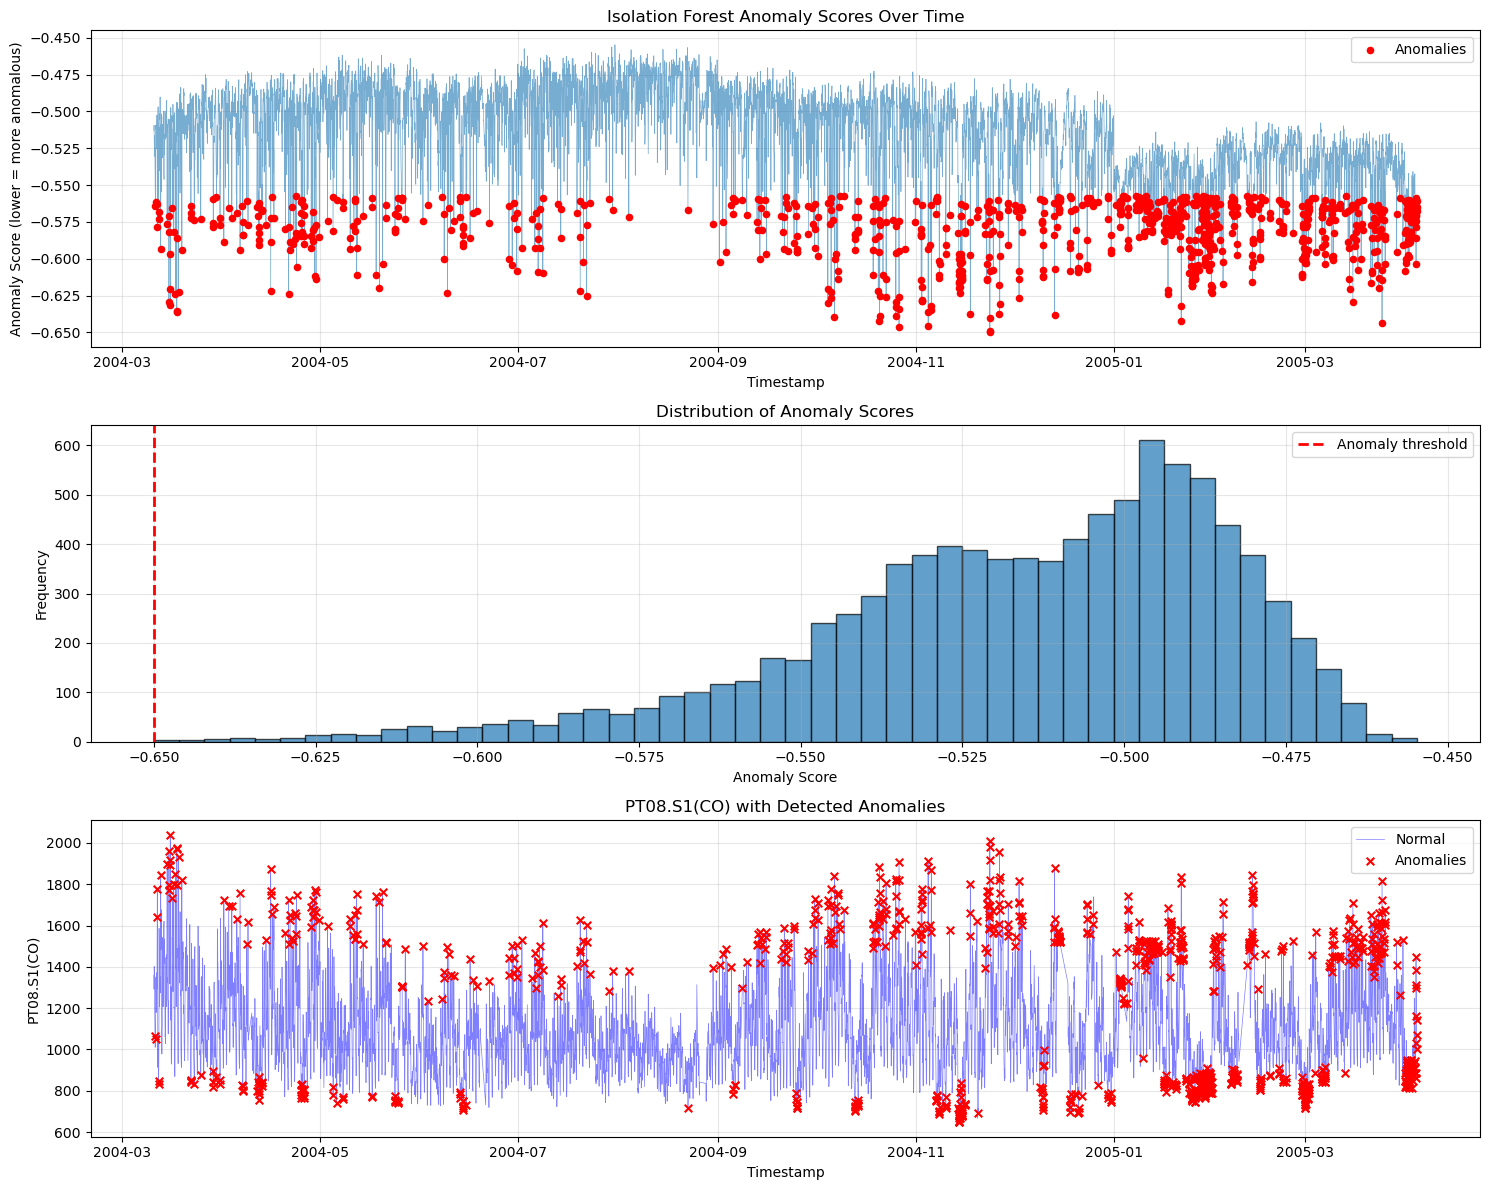

In [68]:
# Visualize anomalies
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Anomaly scores over time
axes[0].plot(results_df.index, results_df['anomaly_score'], alpha=0.6, linewidth=0.5)
axes[0].scatter(
    results_df[results_df['anomaly'] == 1].index,
    results_df[results_df['anomaly'] == 1]['anomaly_score'],
    color='red', s=20, label='Anomalies', zorder=5
)
axes[0].set_title('Isolation Forest Anomaly Scores Over Time')
axes[0].set_xlabel('Timestamp')
axes[0].set_ylabel('Anomaly Score (lower = more anomalous)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of anomaly scores
axes[1].hist(results_df['anomaly_score'], bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(
    results_df[results_df['anomaly'] == 1]['anomaly_score'].min(),
    color='red', linestyle='--', linewidth=2, label='Anomaly threshold'
)
axes[1].set_title('Distribution of Anomaly Scores')
axes[1].set_xlabel('Anomaly Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Sample feature (CO sensor) with anomalies highlighted
sample_feature = 'PT08.S1(CO)'
if sample_feature in df_ts_input_clean.columns:
    axes[2].plot(df_ts_input_clean.index, df_ts_input_clean[sample_feature], 
                 alpha=0.5, linewidth=0.5, label='Normal', color='blue')
    anomaly_indices = results_df[results_df['anomaly'] == 1].index
    axes[2].scatter(
        anomaly_indices,
        df_ts_input_clean.loc[anomaly_indices, sample_feature],
        color='red', s=30, label='Anomalies', zorder=5, marker='x'
    )
    axes[2].set_title(f'{sample_feature} with Detected Anomalies')
    axes[2].set_xlabel('Timestamp')
    axes[2].set_ylabel(sample_feature)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [69]:
# Analyze characteristics of anomalies
print("=== Anomaly Analysis ===\n")

# Statistics for normal vs anomalous points
normal_data = df_ts_input_clean[results_df['anomaly'] == 0]
anomaly_data = df_ts_input_clean[results_df['anomaly'] == 1]

print("Feature Statistics - Normal vs Anomalous:")
print("\nNormal points:")
print(normal_data.describe().T[['mean', 'std', 'min', 'max']].round(2))
print("\nAnomalous points:")
print(anomaly_data.describe().T[['mean', 'std', 'min', 'max']].round(2))

# Show which features have the most extreme values in anomalies
print("\n=== Features with Most Extreme Values in Anomalies ===")
feature_diffs = {}
for col in df_ts_input_clean.columns:
    normal_mean = normal_data[col].mean()
    anomaly_mean = anomaly_data[col].mean()
    feature_diffs[col] = abs(anomaly_mean - normal_mean) / normal_data[col].std()

# Sort by difference
sorted_features = sorted(feature_diffs.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 features with largest differences (normalized by std):")
for feature, diff in sorted_features[:5]:
    print(f"  {feature}: {diff:.2f} std deviations")


=== Anomaly Analysis ===

Feature Statistics - Normal vs Anomalous:

Normal points:
                    mean     std     min      max
PT08.S1(CO)      1088.92  184.53  667.00  1808.00
PT08.S2(NMHC)     928.90  225.65  464.00  1682.67
PT08.S3(NOx)      829.33  214.44  429.00  2095.00
PT08.S4(NO2)     1450.57  298.33  702.00  2337.00
PT08.S5(O3)      1010.40  340.92  346.00  2236.00
day_of_year_sin     0.04    0.72   -1.00     1.00
day_of_year_cos    -0.03    0.69   -1.00     1.00
year_sin            0.00    0.00    0.00     0.00
year_cos            0.58    0.82   -1.00     1.00
hour_sin           -0.01    0.70   -1.00     1.00
hour_cos            0.00    0.72   -1.00     1.00
weekday_sin        -0.02    0.71   -0.97     0.97
weekday_cos        -0.01    0.70   -0.90     1.00
month_sin           0.03    0.73   -1.00     1.00
month_cos          -0.04    0.69   -1.00     1.00

Anomalous points:
                    mean     std     min      max
PT08.S1(CO)      1230.31  389.53  647.00  2040.

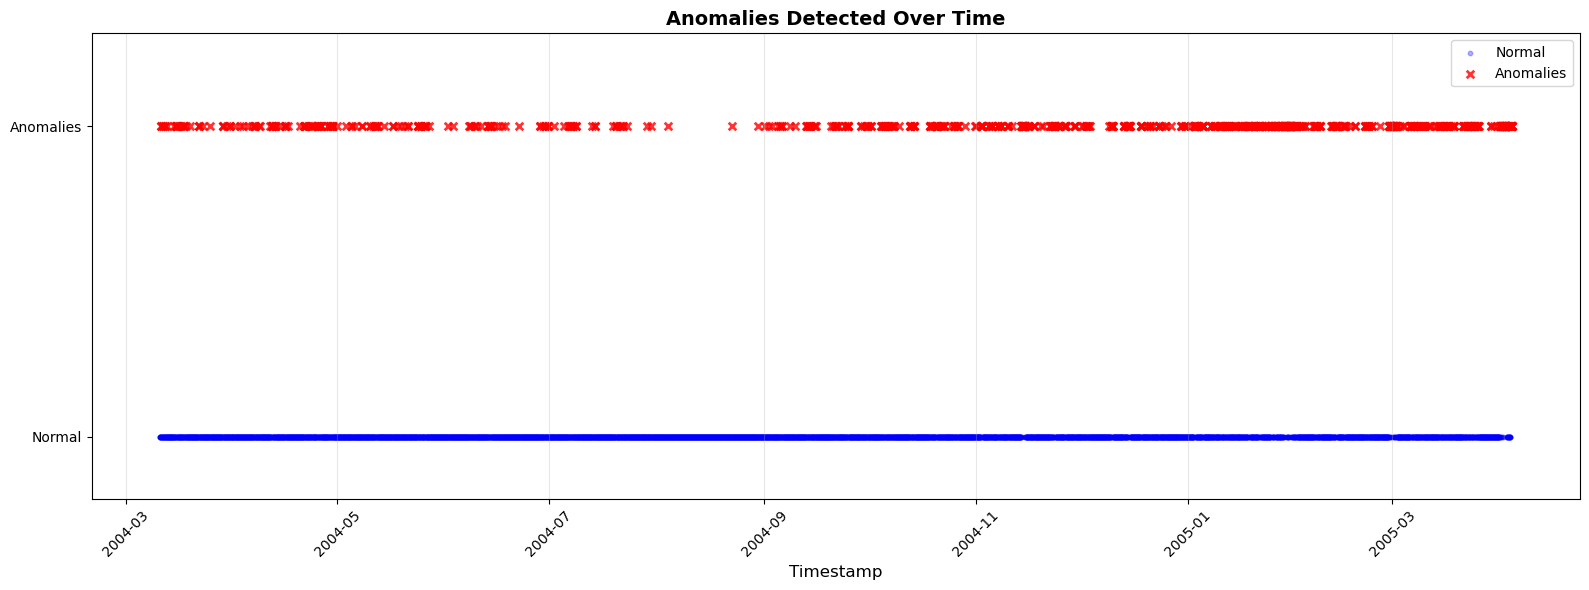

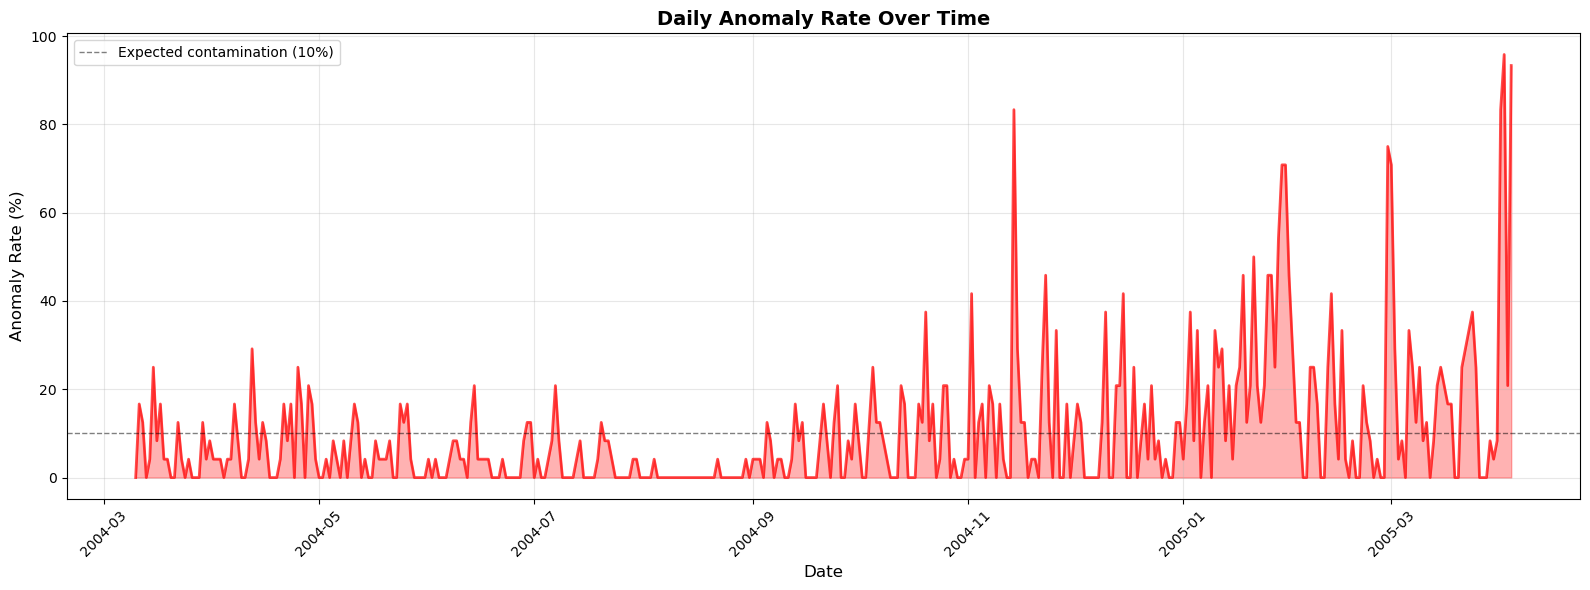

In [70]:
# Plot anomalies over time
fig, ax = plt.subplots(figsize=(16, 6))

# Create a binary plot showing anomalies
# Normal points in blue, anomalies in red
normal_indices = results_df[results_df['anomaly'] == 0].index
anomaly_indices = results_df[results_df['anomaly'] == 1].index

# Plot normal points
ax.scatter(normal_indices, [0] * len(normal_indices), 
           c='blue', alpha=0.3, s=10, label='Normal', marker='o')

# Plot anomalies
ax.scatter(anomaly_indices, [1] * len(anomaly_indices), 
           c='red', alpha=0.8, s=30, label='Anomalies', marker='x', linewidths=2)

# Formatting
ax.set_ylim(-0.2, 1.3)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Normal', 'Anomalies'])
ax.set_xlabel('Timestamp', fontsize=12)
ax.set_title('Anomalies Detected Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Also show anomaly density over time (rolling window)
fig, ax = plt.subplots(figsize=(16, 6))

# Calculate rolling anomaly rate (e.g., per day)
anomaly_series = pd.Series(anomaly_labels, index=results_df.index)
# Resample to daily and calculate anomaly rate
daily_anomaly_rate = anomaly_series.resample('D').mean() * 100

ax.plot(daily_anomaly_rate.index, daily_anomaly_rate.values, 
        linewidth=2, color='red', alpha=0.7)
ax.fill_between(daily_anomaly_rate.index, daily_anomaly_rate.values, 
                alpha=0.3, color='red')
ax.axhline(y=10, color='black', linestyle='--', linewidth=1, 
           label='Expected contamination (10%)', alpha=0.5)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Anomaly Rate (%)', fontsize=12)
ax.set_title('Daily Anomaly Rate Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_55870/2538662237.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = temp_anomaly_df.groupby('temp_bin').agg({


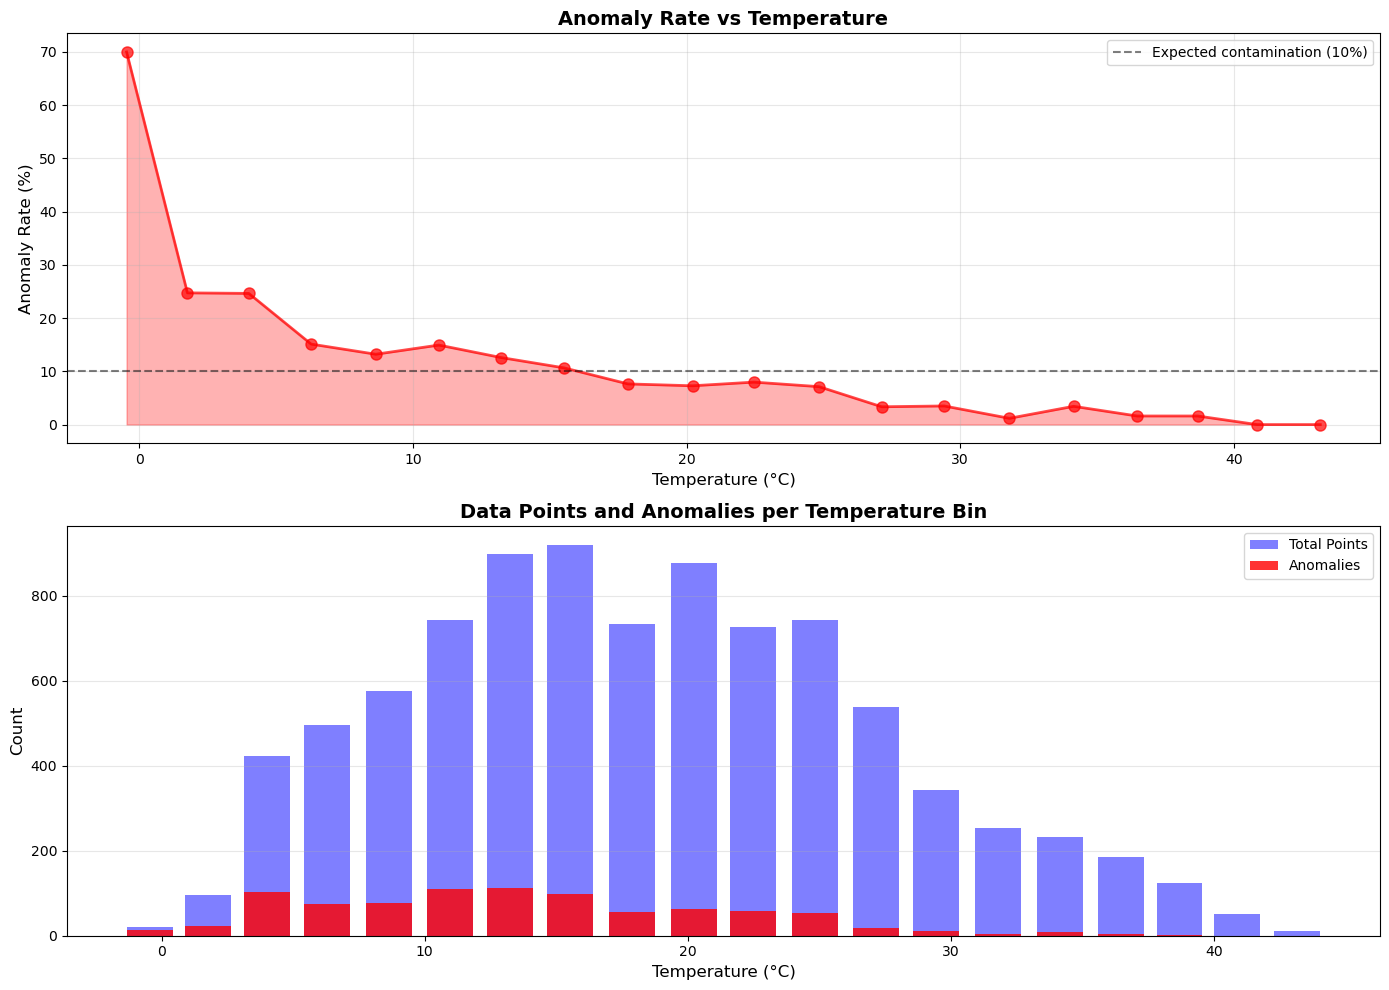

=== Anomaly Rate by Temperature Summary ===

Temperature range: -1.90°C to 44.60°C
Temperature with highest anomaly rate: -0.46°C (70.00%)
Temperature with lowest anomaly rate: 40.85°C (0.00%)
Average anomaly rate: 11.53%


In [71]:
# Plot anomaly rate over temperature
# Use original df_ts for temperature data since it was excluded from model features
if 'T' in df_ts.columns:
    # Get temperature data aligned with results_df index
    temp_data = df_ts.loc[results_df.index, 'T']
    n_bins = 20
    temp_bins = pd.cut(temp_data, bins=n_bins)
    
    # Calculate anomaly rate for each temperature bin
    temp_anomaly_df = pd.DataFrame({
        'temperature': temp_data,
        'temp_bin': temp_bins,
        'anomaly': anomaly_labels
    })
    
    # Group by temperature bin and calculate statistics
    bin_stats = temp_anomaly_df.groupby('temp_bin').agg({
        'temperature': 'mean',  # Mean temperature in each bin
        'anomaly': ['count', 'sum', 'mean']
    })
    
    # Flatten column names
    bin_stats.columns = ['temp_mean', 'total_count', 'anomaly_count', 'anomaly_rate']
    bin_stats['anomaly_rate'] = bin_stats['anomaly_rate'] * 100
    
    # Remove bins with too few points (less than 10)
    bin_stats = bin_stats[bin_stats['total_count'] >= 10]
    
    # Create the plot
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Plot 1: Anomaly rate vs temperature
    ax1 = axes[0]
    ax1.plot(bin_stats['temp_mean'], bin_stats['anomaly_rate'], 
             marker='o', linewidth=2, markersize=8, color='red', alpha=0.7)
    ax1.fill_between(bin_stats['temp_mean'], bin_stats['anomaly_rate'], 
                     alpha=0.3, color='red')
    ax1.axhline(y=10, color='black', linestyle='--', linewidth=1.5, 
                label='Expected contamination (10%)', alpha=0.5)
    ax1.set_xlabel('Temperature (°C)', fontsize=12)
    ax1.set_ylabel('Anomaly Rate (%)', fontsize=12)
    ax1.set_title('Anomaly Rate vs Temperature', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Number of data points and anomalies per temperature bin
    ax2 = axes[1]
    x_pos = bin_stats['temp_mean']
    width = (x_pos.max() - x_pos.min()) / len(x_pos) * 0.8
    
    ax2.bar(x_pos, bin_stats['total_count'], width=width, 
            alpha=0.5, color='blue', label='Total Points')
    ax2.bar(x_pos, bin_stats['anomaly_count'], width=width, 
            alpha=0.8, color='red', label='Anomalies')
    ax2.set_xlabel('Temperature (°C)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Data Points and Anomalies per Temperature Bin', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== Anomaly Rate by Temperature Summary ===\n")
    print(f"Temperature range: {temp_data.min():.2f}°C to {temp_data.max():.2f}°C")
    print(f"Temperature with highest anomaly rate: {bin_stats.loc[bin_stats['anomaly_rate'].idxmax(), 'temp_mean']:.2f}°C ({bin_stats['anomaly_rate'].max():.2f}%)")
    print(f"Temperature with lowest anomaly rate: {bin_stats.loc[bin_stats['anomaly_rate'].idxmin(), 'temp_mean']:.2f}°C ({bin_stats['anomaly_rate'].min():.2f}%)")
    print(f"Average anomaly rate: {bin_stats['anomaly_rate'].mean():.2f}%")


/tmp/ipykernel_55870/1340500034.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rh_bin_stats = rh_anomaly_df.groupby('rh_bin').agg({
/tmp/ipykernel_55870/1340500034.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ah_bin_stats = ah_anomaly_df.groupby('ah_bin').agg({


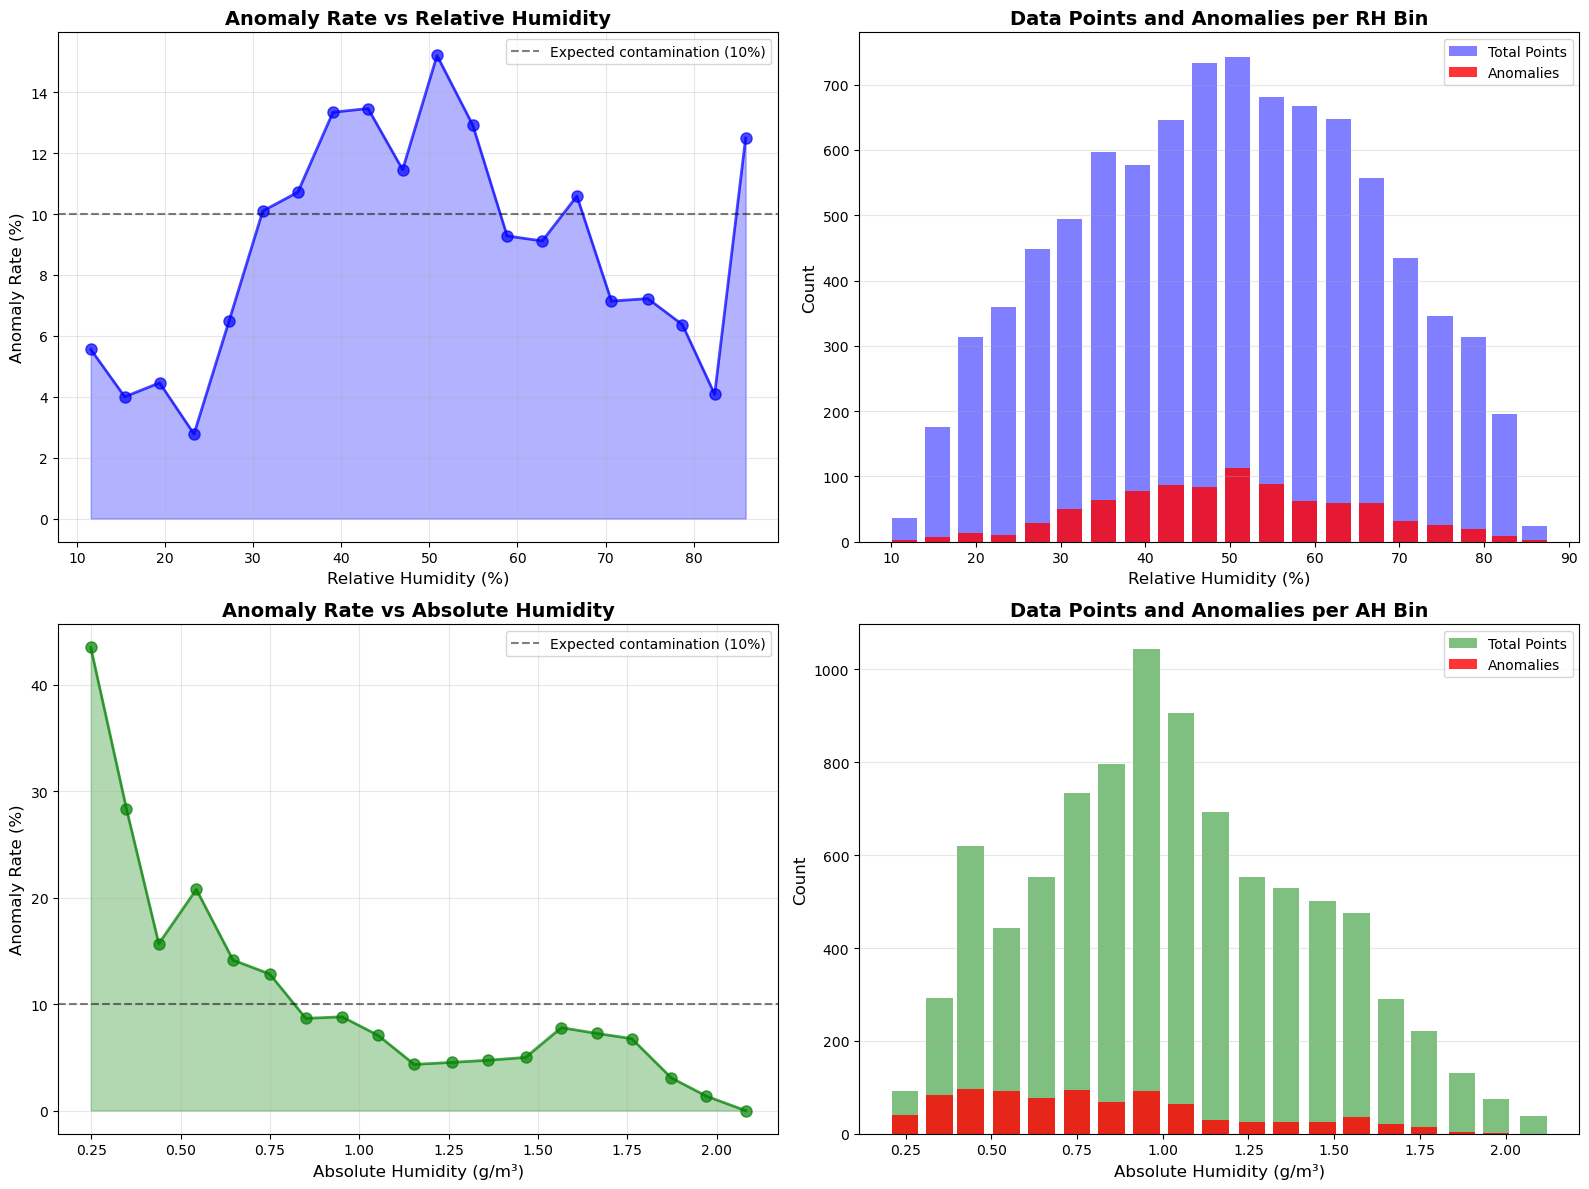

=== Anomaly Rate by Relative Humidity Summary ===

Relative Humidity range: 9.20% to 88.70%
RH with highest anomaly rate: 50.87% (15.21%)
RH with lowest anomaly rate: 23.28% (2.78%)
Average anomaly rate: 8.84%

=== Anomaly Rate by Absolute Humidity Summary ===

Absolute Humidity range: 0.18 g/m³ to 2.23 g/m³
AH with highest anomaly rate: 0.25 g/m³ (43.48%)
AH with lowest anomaly rate: 2.08 g/m³ (0.00%)
Average anomaly rate: 10.76%


In [72]:
# Plot anomaly rate over humidity (Relative Humidity and Absolute Humidity)
# Use original df_ts for humidity data since it was excluded from model features

# Plot for Relative Humidity (RH)
if 'RH' in df_ts.columns:
    # Create humidity bins
    rh_data = df_ts.loc[results_df.index, 'RH']
    n_bins = 20
    rh_bins = pd.cut(rh_data, bins=n_bins)
    
    # Calculate anomaly rate for each humidity bin
    rh_anomaly_df = pd.DataFrame({
        'humidity': rh_data,
        'rh_bin': rh_bins,
        'anomaly': anomaly_labels
    })
    
    # Group by humidity bin and calculate statistics
    rh_bin_stats = rh_anomaly_df.groupby('rh_bin').agg({
        'humidity': 'mean',  # Mean humidity in each bin
        'anomaly': ['count', 'sum', 'mean']
    })
    
    # Flatten column names
    rh_bin_stats.columns = ['rh_mean', 'total_count', 'anomaly_count', 'anomaly_rate']
    rh_bin_stats['anomaly_rate'] = rh_bin_stats['anomaly_rate'] * 100
    
    # Remove bins with too few points (less than 10)
    rh_bin_stats = rh_bin_stats[rh_bin_stats['total_count'] >= 10]

# Create the plot (create figure before conditional plots)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot for Relative Humidity (RH)
if 'RH' in df_ts.columns:
    # Plot 1: Anomaly rate vs Relative Humidity
    ax1 = axes[0, 0]
    ax1.plot(rh_bin_stats['rh_mean'], rh_bin_stats['anomaly_rate'], 
             marker='o', linewidth=2, markersize=8, color='blue', alpha=0.7)
    ax1.fill_between(rh_bin_stats['rh_mean'], rh_bin_stats['anomaly_rate'], 
                     alpha=0.3, color='blue')
    ax1.axhline(y=10, color='black', linestyle='--', linewidth=1.5, 
                label='Expected contamination (10%)', alpha=0.5)
    ax1.set_xlabel('Relative Humidity (%)', fontsize=12)
    ax1.set_ylabel('Anomaly Rate (%)', fontsize=12)
    ax1.set_title('Anomaly Rate vs Relative Humidity', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Number of data points and anomalies per RH bin
    ax2 = axes[0, 1]
    x_pos = rh_bin_stats['rh_mean']
    width = (x_pos.max() - x_pos.min()) / len(x_pos) * 0.8 if len(x_pos) > 0 else 1
    
    ax2.bar(x_pos, rh_bin_stats['total_count'], width=width, 
            alpha=0.5, color='blue', label='Total Points')
    ax2.bar(x_pos, rh_bin_stats['anomaly_count'], width=width, 
            alpha=0.8, color='red', label='Anomalies')
    ax2.set_xlabel('Relative Humidity (%)', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Data Points and Anomalies per RH Bin', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')

# Plot for Absolute Humidity (AH)
if 'AH' in df_ts.columns:
    # Create absolute humidity bins
    ah_data = df_ts.loc[results_df.index, 'AH']
    n_bins = 20
    ah_bins = pd.cut(ah_data, bins=n_bins)
    
    # Calculate anomaly rate for each absolute humidity bin
    ah_anomaly_df = pd.DataFrame({
        'humidity': ah_data,
        'ah_bin': ah_bins,
        'anomaly': anomaly_labels
    })
    
    # Group by absolute humidity bin and calculate statistics
    ah_bin_stats = ah_anomaly_df.groupby('ah_bin').agg({
        'humidity': 'mean',  # Mean absolute humidity in each bin
        'anomaly': ['count', 'sum', 'mean']
    })
    
    # Flatten column names
    ah_bin_stats.columns = ['ah_mean', 'total_count', 'anomaly_count', 'anomaly_rate']
    ah_bin_stats['anomaly_rate'] = ah_bin_stats['anomaly_rate'] * 100
    
    # Remove bins with too few points (less than 10)
    ah_bin_stats = ah_bin_stats[ah_bin_stats['total_count'] >= 10]
    
    # Plot 3: Anomaly rate vs Absolute Humidity
    ax3 = axes[1, 0]
    ax3.plot(ah_bin_stats['ah_mean'], ah_bin_stats['anomaly_rate'], 
             marker='o', linewidth=2, markersize=8, color='green', alpha=0.7)
    ax3.fill_between(ah_bin_stats['ah_mean'], ah_bin_stats['anomaly_rate'], 
                     alpha=0.3, color='green')
    ax3.axhline(y=10, color='black', linestyle='--', linewidth=1.5, 
                label='Expected contamination (10%)', alpha=0.5)
    ax3.set_xlabel('Absolute Humidity (g/m³)', fontsize=12)
    ax3.set_ylabel('Anomaly Rate (%)', fontsize=12)
    ax3.set_title('Anomaly Rate vs Absolute Humidity', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Number of data points and anomalies per AH bin
    ax4 = axes[1, 1]
    x_pos = ah_bin_stats['ah_mean']
    width = (x_pos.max() - x_pos.min()) / len(x_pos) * 0.8 if len(x_pos) > 0 else 1
    
    ax4.bar(x_pos, ah_bin_stats['total_count'], width=width, 
            alpha=0.5, color='green', label='Total Points')
    ax4.bar(x_pos, ah_bin_stats['anomaly_count'], width=width, 
            alpha=0.8, color='red', label='Anomalies')
    ax4.set_xlabel('Absolute Humidity (g/m³)', fontsize=12)
    ax4.set_ylabel('Count', fontsize=12)
    ax4.set_title('Data Points and Anomalies per AH Bin', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')

# Hide unused subplots if only one humidity type is available
if 'RH' not in df_ts.columns:
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')
if 'AH' not in df_ts.columns:
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Print summary statistics
if 'RH' in df_ts.columns:
    print("=== Anomaly Rate by Relative Humidity Summary ===\n")
    print(f"Relative Humidity range: {rh_data.min():.2f}% to {rh_data.max():.2f}%")
    print(f"RH with highest anomaly rate: {rh_bin_stats.loc[rh_bin_stats['anomaly_rate'].idxmax(), 'rh_mean']:.2f}% ({rh_bin_stats['anomaly_rate'].max():.2f}%)")
    print(f"RH with lowest anomaly rate: {rh_bin_stats.loc[rh_bin_stats['anomaly_rate'].idxmin(), 'rh_mean']:.2f}% ({rh_bin_stats['anomaly_rate'].min():.2f}%)")
    print(f"Average anomaly rate: {rh_bin_stats['anomaly_rate'].mean():.2f}%\n")

if 'AH' in df_ts.columns:
    print("=== Anomaly Rate by Absolute Humidity Summary ===\n")
    print(f"Absolute Humidity range: {ah_data.min():.2f} g/m³ to {ah_data.max():.2f} g/m³")
    print(f"AH with highest anomaly rate: {ah_bin_stats.loc[ah_bin_stats['anomaly_rate'].idxmax(), 'ah_mean']:.2f} g/m³ ({ah_bin_stats['anomaly_rate'].max():.2f}%)")
    print(f"AH with lowest anomaly rate: {ah_bin_stats.loc[ah_bin_stats['anomaly_rate'].idxmin(), 'ah_mean']:.2f} g/m³ ({ah_bin_stats['anomaly_rate'].min():.2f}%)")
    print(f"Average anomaly rate: {ah_bin_stats['anomaly_rate'].mean():.2f}%")


In [ ]:
# Analyze trend in anomalies over time
from scipy.stats import linregress
from datetime import datetime

# Calculate daily anomaly rate
anomaly_series = pd.Series(anomaly_labels, index=results_df.index)
daily_anomaly_rate = anomaly_series.resample('D').mean() * 100

# Calculate monthly anomaly rate for smoother trend
monthly_anomaly_rate = anomaly_series.resample('M').mean() * 100

# Convert dates to numeric for regression
daily_dates_numeric = (daily_anomaly_rate.index - daily_anomaly_rate.index[0]).days
monthly_dates_numeric = (monthly_anomaly_rate.index - monthly_anomaly_rate.index[0]).days

# Perform linear regression on daily rates
daily_slope, daily_intercept, daily_r_value, daily_p_value, daily_std_err = linregress(
    daily_dates_numeric, daily_anomaly_rate.values
)

# Perform linear regression on monthly rates
monthly_slope, monthly_intercept, monthly_r_value, monthly_p_value, monthly_std_err = linregress(
    monthly_dates_numeric, monthly_anomaly_rate.values
)

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Plot 1: Daily anomaly rate with trend line
ax1 = axes[0]
ax1.plot(daily_anomaly_rate.index, daily_anomaly_rate.values, 
         linewidth=1.5, color='red', alpha=0.6, label='Daily Anomaly Rate')
# Add trend line
daily_trend = daily_slope * daily_dates_numeric + daily_intercept
ax1.plot(daily_anomaly_rate.index, daily_trend, 
         linewidth=2, color='blue', linestyle='--', 
         label=f'Trend (slope: {daily_slope:.4f}%/day)')
ax1.axhline(y=10, color='black', linestyle=':', linewidth=1, 
           label='Expected contamination (10%)', alpha=0.5)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Anomaly Rate (%)', fontsize=12)
ax1.set_title('Daily Anomaly Rate Over Time with Trend Line', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly anomaly rate with trend line
ax2 = axes[1]
ax2.plot(monthly_anomaly_rate.index, monthly_anomaly_rate.values, 
         marker='o', linewidth=2, markersize=8, color='red', alpha=0.7, label='Monthly Anomaly Rate')
# Add trend line
monthly_trend = monthly_slope * monthly_dates_numeric + monthly_intercept
ax2.plot(monthly_anomaly_rate.index, monthly_trend, 
         linewidth=2, color='blue', linestyle='--', 
         label=f'Trend (slope: {monthly_slope:.4f}%/day)')
ax2.axhline(y=10, color='black', linestyle=':', linewidth=1, 
           label='Expected contamination (10%)', alpha=0.5)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Anomaly Rate (%)', fontsize=12)
ax2.set_title('Monthly Anomaly Rate Over Time with Trend Line', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative anomaly count over time
ax3 = axes[2]
cumulative_anomalies = anomaly_series.cumsum()
cumulative_total = pd.Series(1, index=results_df.index).cumsum()
cumulative_rate = (cumulative_anomalies / cumulative_total) * 100

ax3.plot(cumulative_rate.index, cumulative_rate.values, 
         linewidth=2, color='purple', alpha=0.7, label='Cumulative Anomaly Rate')
ax3.axhline(y=10, color='black', linestyle=':', linewidth=1, 
           label='Expected contamination (10%)', alpha=0.5)
ax3.set_xlabel('Date', fontsize=12)
ax3.set_ylabel('Cumulative Anomaly Rate (%)', fontsize=12)
ax3.set_title('Cumulative Anomaly Rate Over Time', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print trend analysis
print("=== Trend Analysis: Anomalies Over Time ===\n")
print("Daily Anomaly Rate Trend:")
print(f"  Slope: {daily_slope:.6f}% per day")
print(f"  R-squared: {daily_r_value**2:.4f}")
print(f"  P-value: {daily_p_value:.6f}")
print(f"  Interpretation: {'Significant increase' if daily_slope > 0 and daily_p_value < 0.05 else 'Significant decrease' if daily_slope < 0 and daily_p_value < 0.05 else 'No significant trend'}")
print(f"\n  First month average: {daily_anomaly_rate.iloc[:30].mean():.2f}%")
print(f"  Last month average: {daily_anomaly_rate.iloc[-30:].mean():.2f}%")
print(f"  Change: {daily_anomaly_rate.iloc[-30:].mean() - daily_anomaly_rate.iloc[:30].mean():.2f} percentage points")

print("\nMonthly Anomaly Rate Trend:")
print(f"  Slope: {monthly_slope:.6f}% per day")
print(f"  R-squared: {monthly_r_value**2:.4f}")
print(f"  P-value: {monthly_p_value:.6f}")
print(f"  Interpretation: {'Significant increase' if monthly_slope > 0 and monthly_p_value < 0.05 else 'Significant decrease' if monthly_slope < 0 and monthly_p_value < 0.05 else 'No significant trend'}")

print(f"\nOverall Statistics:")
print(f"  Total time period: {results_df.index[0]} to {results_df.index[-1]}")
print(f"  Total days: {(results_df.index[-1] - results_df.index[0]).days}")
print(f"  Overall anomaly rate: {anomaly_labels.mean() * 100:.2f}%")
print(f"  First half anomaly rate: {anomaly_labels[:len(anomaly_labels)//2].mean() * 100:.2f}%")
print(f"  Second half anomaly rate: {anomaly_labels[len(anomaly_labels)//2:].mean() * 100:.2f}%")
print(f"  Difference: {(anomaly_labels[len(anomaly_labels)//2:].mean() - anomaly_labels[:len(anomaly_labels)//2].mean()) * 100:.2f} percentage points")
